In [394]:
import pandas as pd
import csv
import pickle
import numpy as np
from IPython.display import display
import multiprocessing
from multiprocessing import Pool
import math
from tqdm import tqdm
import time
import traceback
from sklearn.externals import joblib
import xgboost as xgb
import json
import time
from training import training_procedure

In [375]:
event = 'givenchy'
start_hour = 9


In [376]:
path = "/Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/"
#model = joblib.load(path+"/xgb_model_GIVENCHY (2).dat")
#model = joblib.load(path+event+"_xgb_model_"+str(start_hour)+"_hrs.dat")
#model = joblib.load(path+'xgb_model_6_hrs.dat')
#model = joblib.load("/Users/jay/Downloads/new_files/xgb_model_GIVENCHY.dat")

In [377]:
def load_pickle_file(pickled_file):
    print(f'Loading data file from {pickled_file}')
    infile = open(pickled_file,'rb')
    unpickled_file = pickle.load(infile)
    print(f'Loaded {len(unpickled_file)} entries')
    infile.close()
    return unpickled_file
          
    
def save_pickle_file(path, data):
    print('Dumping data to path {}'.format(path))
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    print('Finished dumping data to path {}'.format(path))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x/y



In [378]:
initial_features = load_pickle_file(path+str(start_hour)+'_hrs_data.pkl')
initial_dataset = load_pickle_file(path+'network_simulation_'+str(start_hour)+'_hrs.pkl')
users = load_pickle_file(path+event+"_users.dat")
users.reset_index(drop =True , inplace =True)

Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/9_hrs_data.pkl
Loaded 5973 entries
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/network_simulation_9_hrs.pkl
Loaded 5973 entries
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/givenchy_users.dat
Loaded 5973 entries


In [379]:
in_degree = list(initial_dataset.friends_count)
out_degree = list(initial_dataset.followers_count)
degree = (users.friends_count+users.followers_count).tolist()

In [380]:
def process_data(source_id,target_id,features,network_simulation,current_time):
    
    if isinstance(network_simulation.loc[target_id,'source_candidates'],list):
        
        source_candidates = sorted(network_simulation.loc[target_id,'source_candidates'])
        sources = source_candidates

        first_source_index = source_candidates[0]
        first_source_row = network_simulation.loc[first_source_index]
        first_source_seed_row = network_simulation.loc[first_source_row['seed_index']]

        sources_dataframe = network_simulation.loc[sources]
        degreeList = list(degree[i] for i in sources)
        inDegreeList = list(in_degree[i] for i in sources)
        outDegreeList = list(out_degree[i] for i in sources)
        degreeList = list(network_simulation.loc[i, 'followers_count'] + network_simulation.loc[i, 'friends_count']  for i in sources)
        timeList = [current_time - network_simulation.loc[x,'time_lapsed'] for x in sources]


        last_source_index = sources[-1]    
        try:
            last_source_row = network_simulation.loc[last_source_index]
            last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]
        except:
            print(f"target_index:{target_id}")
            print(f"last_source_index:{last_source_index}")
            

        #Extraction
        #Columns which are added for simulation, but they are not used as features for model prediction

        user_row = network_simulation.loc[target_id]


        # UsM: User metadata                    

        features.loc[target_id,'UsM_deltaDays0'] = first_source_row.user_created_days
        features.loc[target_id,'UsM_statusesCount0'] = first_source_row.statuses_count
        features.loc[target_id,'UsM_followersCount0'] = first_source_row.followers_count
        features.loc[target_id,'UsM_favouritesCount0'] = first_source_row.favourites_count
        features.loc[target_id,'UsM_friendsCount0'] = first_source_row.friends_count
        features.loc[target_id,'UsM_listedCount0'] = first_source_row.listed_count
        features.loc[target_id,'UsM_normalizedUserStatusesCount0'] = first_source_row.normalized_statuses_count
        features.loc[target_id,'UsM_normalizedUserFollowersCount0'] = first_source_row.normalized_followers_count
        features.loc[target_id,'UsM_normalizedUserFavouritesCount0'] = first_source_row.normalized_favourites_count
        features.loc[target_id,'UsM_normalizedUserListedCount0'] = first_source_row.normalized_listed_count
        features.loc[target_id,'UsM_normalizedUserFriendsCount0'] = first_source_row.normalized_friends_count
        features.loc[target_id,'UsM_deltaDays-1'] = last_source_row.user_created_days
        features.loc[target_id,'UsM_statusesCount-1'] = last_source_row.statuses_count
        features.loc[target_id,'UsM_followersCount-1'] = last_source_row.followers_count
        features.loc[target_id,'UsM_favouritesCount-1'] = last_source_row.favourites_count
        features.loc[target_id,'UsM_friendsCount-1'] = last_source_row.friends_count
        features.loc[target_id,'UsM_listedCount-1'] = last_source_row.listed_count
        features.loc[target_id,'UsM_normalizedUserStatusesCount-1'] = last_source_row.normalized_statuses_count
        features.loc[target_id,'UsM_normalizedUserFollowersCount-1'] = last_source_row.normalized_followers_count
        features.loc[target_id,'UsM_normalizedUserFavouritesCount-1'] = last_source_row.normalized_favourites_count
        features.loc[target_id,'UsM_normalizedUserListedCount-1'] = last_source_row.normalized_listed_count
        features.loc[target_id,'UsM_normalizedUserFriendsCount-1'] = last_source_row.normalized_friends_count
        # TwM: Tweet metadata
        features.loc[target_id,'TwM_t0'] = round(timeList[0], 1)
        features.loc[target_id,'TwM_tSeed0'] = round(current_time - first_source_seed_row['time_lapsed'], 1)
        features.loc[target_id,'TwM_t-1'] = round(timeList[-1], 1)
        features.loc[target_id,'TwM_tSeed-1'] = round(current_time - last_source_seed_row['time_lapsed'], 1)
        features.loc[target_id,'TwM_tCurrent'] = current_time
        # Nw: Network
        features.loc[target_id,'Nw_degree'] = degree[target_id]
        features.loc[target_id,'Nw_inDegree'] = in_degree[target_id]
        features.loc[target_id,'Nw_outDegree'] = out_degree[target_id]
        features.loc[target_id,'Nw_degree0'] = degree[first_source_index]
        features.loc[target_id,'Nw_inDegree0'] = in_degree[first_source_index]
        features.loc[target_id,'Nw_outDegree0'] = out_degree[first_source_index]
        features.loc[target_id,'Nw_degree-1'] = degree[last_source_index]
        features.loc[target_id,'Nw_inDegree-1'] = in_degree[last_source_index]
        features.loc[target_id,'Nw_outDegree-1'] = out_degree[last_source_index]
        features.loc[target_id,'Nw_degreeSeed0'] = degree[int(first_source_row['seed_index'])]
        features.loc[target_id,'Nw_inDegreeSeed0'] = in_degree[int(first_source_row['seed_index'])]
        features.loc[target_id,'Nw_outDegreeSeed0'] = out_degree[int(first_source_row['seed_index'])]
        features.loc[target_id,'Nw_degreeSeed-1'] = degree[int(last_source_row['seed_index'])]
        features.loc[target_id,'Nw_inDegreeSeed-1'] = in_degree[int(last_source_row['seed_index'])]
        features.loc[target_id,'Nw_outDegreeSeed-1'] = out_degree[int(last_source_row['seed_index'])]
        # SNw: Spreading Network
        features.loc[target_id,'SNw_nFriendsInfected'] = len(sources)
        features.loc[target_id,'SNw_friendsInfectedRatio'] = safe_division(len(sources), user_row['friends_count'])
        features.loc[target_id,'SNw_generation0'] = first_source_row['generation']
        features.loc[target_id,'SNw_generation-1'] = last_source_row['generation']
        features.loc[target_id,'SNw_timeSinceSeed0'] = first_source_row['time_since_seed']
        features.loc[target_id,'SNw_timeSinceSeed-1'] = last_source_row['time_since_seed']

        infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
        total_nodes_infected = infected_dataframe.shape[0]
        total_in_degree = sum(infected_dataframe.friends_count)
        total_out_degree = sum(infected_dataframe.followers_count)

        features.loc[target_id,'SNw_totalNodesInfected'] = total_nodes_infected
        features.loc[target_id,'SNw_nodeInfectedCentrality'] = len(sources)/total_nodes_infected
        features.loc[target_id,'SNw_totalInDegree'] = total_in_degree
        features.loc[target_id,'SNw_totalOutDegree'] = total_out_degree
        features.loc[target_id,'SNw_inDegreeCentrality'] = in_degree[target_id]/total_in_degree
        features.loc[target_id,'SNw_inDegreeCentrality0'] = in_degree[first_source_index]/total_in_degree
        features.loc[target_id,'SNw_inDegreeCentrality-1'] = in_degree[last_source_index]/total_in_degree
        features.loc[target_id,'SNw_outDegreeCentrality'] = out_degree[target_id]/total_out_degree
        features.loc[target_id,'SNw_outDegreeCentrality0'] = out_degree[first_source_index]/total_out_degree
        features.loc[target_id,'SNw_outDegreeCentrality-1'] = out_degree[last_source_index]/total_out_degree
        features.loc[target_id,'SNw_inDegreeCentralitySeed0'] = in_degree[int(first_source_row['seed_index'])]/total_in_degree
        features.loc[target_id,'SNw_outDegreeCentralitySeed0'] = out_degree[int(first_source_row['seed_index'])]/total_out_degree
        features.loc[target_id,'SNw_inDegreeCentralitySeed-1'] = in_degree[int(last_source_row['seed_index'])]/total_in_degree
        features.loc[target_id,'SNw_outDegreeCentralitySeed-1'] = out_degree[int(last_source_row['seed_index'])]/total_out_degree
        # Stat: Statistical
        features.loc[target_id,'Stat_average_kOut'] = round(mean(degreeList), 1)
        features.loc[target_id,'Stat_average_t'] = round(mean(timeList), 1)
        features.loc[target_id,'Stat_average_deltaDays'] = sources_dataframe.user_created_days.mean()
        features.loc[target_id,'Stat_average_statusesCount'] = sources_dataframe.statuses_count.mean()
        features.loc[target_id,'Stat_average_followersCount'] = sources_dataframe.followers_count.mean()
        features.loc[target_id,'Stat_average_favouritesCount'] = sources_dataframe.favourites_count.mean()
        features.loc[target_id,'Stat_average_friendsCount'] = sources_dataframe.friends_count.mean()
        features.loc[target_id,'Stat_average_listedCount'] = sources_dataframe.listed_count.mean()
        features.loc[target_id,'Stat_average_normalizedUserStatusesCount'] = sources_dataframe.normalized_statuses_count.mean()
        features.loc[target_id,'Stat_average_normalizedUserFollowersCount'] = sources_dataframe.normalized_followers_count.mean()
        features.loc[target_id,'Stat_average_normalizedUserFavouritesCount'] = sources_dataframe.normalized_favourites_count.mean()
        features.loc[target_id,'Stat_average_normalizedUserListedCount'] = sources_dataframe.normalized_listed_count.mean()
        features.loc[target_id,'Stat_average_normalizedUserFriendsCount'] = sources_dataframe.normalized_friends_count.mean()
        features.loc[target_id,'Stat_max_kOut'] = max(degreeList)
        features.loc[target_id,'Stat_min_kOut'] = min(degreeList)
    #processed_dataframe = pd.DataFrame(features)
    return features



In [381]:
def simulation(features,dataset,network_simulation,current_time,model):
    infected_users_indices = network_simulation[network_simulation['time_lapsed'].isnull() == False].index.values
    for i in infected_users_indices:
        if isinstance(network_simulation.loc[i,'followers_list'],list):
            
            followers_indices = [network_simulation[network_simulation['id'] == x].index.values.item() for x in network_simulation.loc[i].followers_list]
            
            
            uninfected_followers_indices = [y for y in followers_indices if np.isnan(network_simulation.loc[y, 'time_lapsed']) == True]

            if len(uninfected_followers_indices) > 0:
                #print(f"uninfected followers are there")
                for j in uninfected_followers_indices:
                    #print(f"j:{j}")
                    source_index = i
                    target_index = j
                    processed_dataframe = process_data(source_index,target_index,features,network_simulation,current_time)
                    #print(f"len processed_dataframe: {processed_dataframe[0,:]}")
                    try:
                        valid_row = processed_dataframe.loc[[target_index]]
                    except:
                        print(f"source_index:{source_index}")
                        print(f"target_index:{target_index}")
                        processed_dataframe.to_csv(path+'processed_dataframe.csv')
                        print(processed_dataframe.loc[[target_index]])
                    #print(f"(valid_row.columns):{list(valid_row.columns.values)}")
                    
                    #for i in range(valid_row.columns):
                        #print(f"valid_row:{i}")
                    #valid = valid_row.drop(['user_id','infected_status','infection_time','followers_list','Nw_inDegree','Nw_outDegree'],axis=1)
                    valid = valid_row.drop(['user_id','infected_status','infection_time','followers_list'],axis=1)
                    #print(f"list(valid.columns):{list(valid.columns)}")
                    valid = valid.astype('float64')

                    columns = list(valid.columns)
                    X = valid[columns]
                    
                    pre_data = xgb.DMatrix(X)
                    #print(f"pre_data.columns:{pre_data}")
                    infec = model.predict(pre_data)
                    if infec > 0.5:
                        print("Infected")
                        network_simulation.loc[target_index,'time_lapsed'] = current_time
                        network_simulation.loc[target_index,'source_index'] = source_index
                        network_simulation.loc[target_index,'seed_index'] = network_simulation.loc[source_index,'seed_index']
                        network_simulation.loc[target_index,'generation'] = network_simulation.loc[source_index,'generation'] + 1
                        seed_index = network_simulation.loc[target_index,'seed_index']
                        network_simulation.loc[target_index,'time_since_seed'] = current_time - network_simulation.loc[seed_index,'time_lapsed']
                        followers_of_node = network_simulation.loc[target_index,'followers_list'] 
                        if isinstance(followers_of_node,list):
                            for f in followers_of_node:
                                if np.isnan(network_simulation[network_simulation['id'] == f]['time_lapsed'].values):
                                    follower_index = network_simulation[network_simulation['id'] == f].index.values
                                    try:
                                        list(network_simulation.loc[follower_index,'source_candidates'].values).append(f)
                                    except:
                                        print(f"source_candidates:{network_simulation.loc[follower_index,'source_candidates'].values}")
                                        print(f"f:{f}")

    return network_simulation

Simulation started
current_time:540
training started for i:6
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/9_hrs_data.pkl
Loaded 5973 entries
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/givenchy_users.dat
Loaded 5973 entries
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
I

Loaded 5973 entries
Infected
current_time:900
training started for i:18
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/15_hrs_data.pkl
Loaded 5973 entries
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/givenchy_users.dat
Loaded 5973 entries
Infected
Infected
Infected
Infected
Infected
current_time:930
Infected
Infected
current_time:960
Infected
Infected
Infected
Infected
Infected
Infected
Infected
current_time:990
Infected
Infected
Infected
Infected
Infected
Infected
current_time:1020
Infected
current_time:1050
Infected
Infected
Infected
Infected
Infected
Infected
Infected
Infected
current_time:1080
Infected
Infected
current_time:1110
Infected
current_time:1140
Infected
Infected
current_time:1170
Infected
Infected
Infected
Infected
current_time:1200
Infected
current_time:1230
Infected
current_time:1260
Infected
current_time:1290
Infected
Infected
Infected
current_time:1320
Infected
current_time:1350
Infected
current_time:1380
current_ti

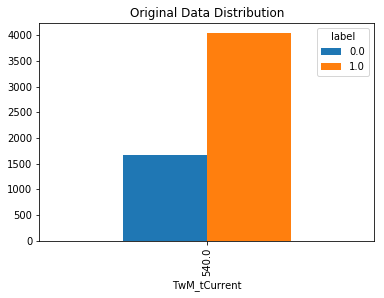

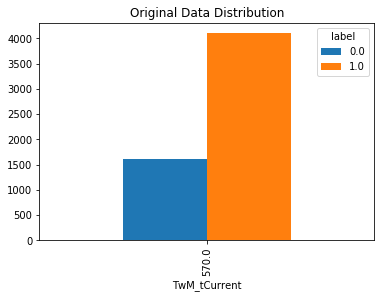

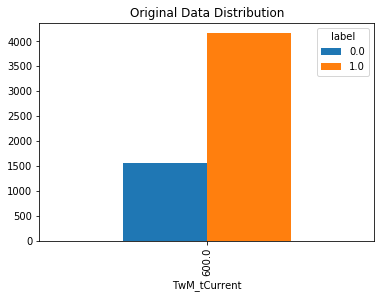

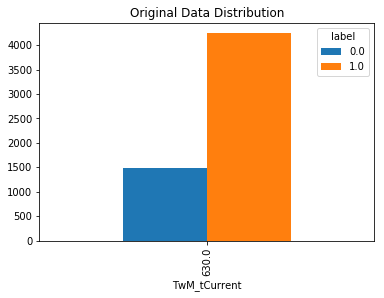

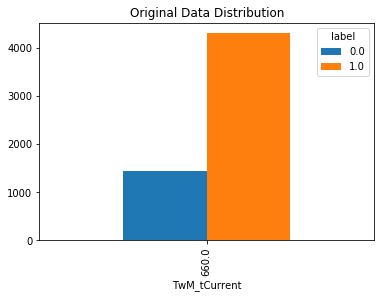

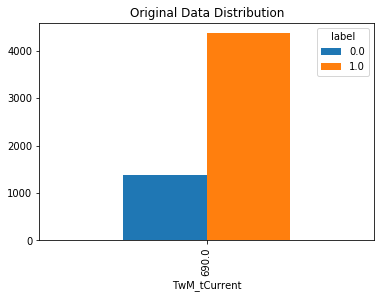

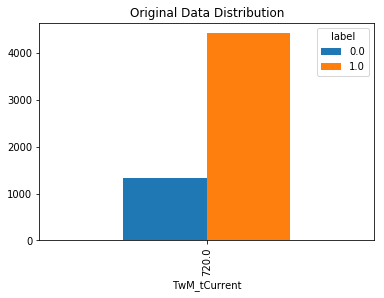

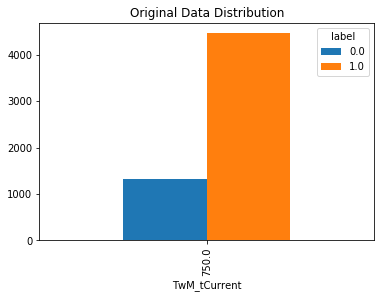

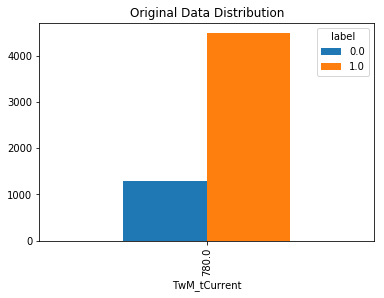

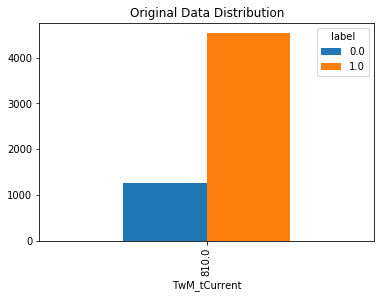

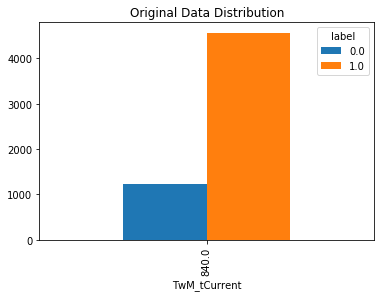

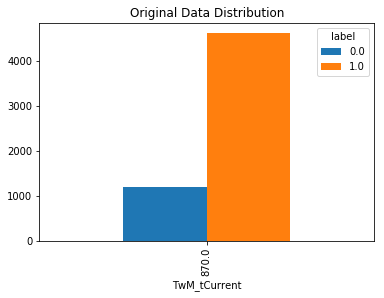

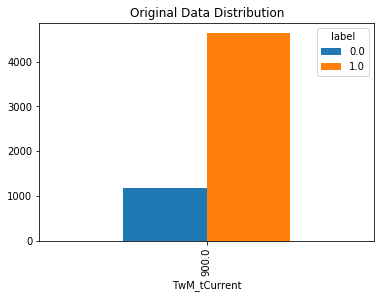

In [382]:
total_time_duration = 24*60
interval = 30
#current_time = 360
#current_time = 420
#current_time = 480
#current_time = 540
#current_time = 720
current_time = 540

start_time_list = [6,630,7,730,8,830,9,930,10,1030,11,1130,12,1230,13,1330,14,1430,15]

features = initial_features
network_simulation = initial_dataset

print("Simulation started")
start_time = time.time()

i = 6
model = None
while current_time < total_time_duration:
    print(f"current_time:{current_time}")
    if i <= 18:
        print(f"training started for i:{i}")
        model = training_procedure(start_time_list[i])
    
    network_simulation = simulation(features,initial_dataset,network_simulation,current_time,model)
    #print(f"current_time:{current_time}")
    current_time += interval
    i += 1
    
print(f"Simulation finished after {round((time.time() - start_time)/60,2)} minutes")
    


In [383]:
network_simulation.to_csv(path+event+'_simulation_result_'+str(start_hour)+'hrs_'+str(start_hour)+'_hrs_model_retrained_correct_seed_index.csv',index=False)
#network_simulation.to_csv(path+'Results/after_time/original/results/'+event+'_simulation_result_'+str(start_hour)+'hrs_'+str(start_hour)+'_hrs.csv',index=False)

In [349]:
#Precision Recall:
current_time = 360

simulation_comparison = pd.concat([network_simulation['time_lapsed'],users['time_lapsed']],axis = 1)
column_names = ['nw_time_lapsed','usr_time_lapsed']
simulation_comparison.columns = column_names

simulation_comparison['both_infected'] = simulation_comparison.apply(lambda x: 1 if (np.isnan(x['nw_time_lapsed']) == False)
                                                                          & (np.isnan(x['usr_time_lapsed']) == False)
                                                                     & (x['usr_time_lapsed'] > current_time)
                                                                     else 0,axis = 1)

true_positive = simulation_comparison['both_infected'].sum()
total_predicted_positive = len(simulation_comparison[np.isnan(simulation_comparison['nw_time_lapsed']) == False])
precision = true_positive/total_predicted_positive
total_actual_positive = len(simulation_comparison[np.isnan(simulation_comparison['usr_time_lapsed']) == False])
recall = true_positive/total_actual_positive
f1_score = (2*(precision * recall))/(precision + recall)

# accuracy['simulation_start_time'].append(6)
# accuracy['precision'].append(precision)
# accuracy['recall'].append(recall)

# accuracy['f1_score'].append(f1_score)




